<a href="https://colab.research.google.com/github/hashemwa/CSE-482-Project/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from collections import Counter
from nltk.util import bigrams
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('twitter_training.csv', names=['tweet_id', 'subject', 'sentiment', 'review_text'])

In [4]:
## Cleaning

ENGLISH_STOPWORDS_SET = set(stopwords.words('english'))

def remove_stopwords_from_list(token_list):
    """
    Filters a list of tokens, returning only those not in the stopword set.
    """
    # This list comprehension is the efficient way to filter tokens
    return [word for word in token_list if word not in ENGLISH_STOPWORDS_SET]

def remove_punctuation_from_list(token_list):
    """
    Filters a list of tokens, returning only those not in the stopword set.
    """
    # This list comprehension is the efficient way to filter tokens
    return [word for word in token_list if word not in punctuation]

df = df[df["sentiment"].isin(["Positive", "Negative"])]

df["review_text"] = df["review_text"].astype("string")

df["cleaned_text"] = df["review_text"].str.lower()

df = df.dropna(subset= ["cleaned_text"])

# Remove whitespace
df["cleaned_text"] = df["cleaned_text"].str.replace(r'\s+', ' ', regex=True)

df = df.drop_duplicates(subset = ["cleaned_text"])

df["tokens"] = df["cleaned_text"].apply(word_tokenize)

# remove punctuation
df["tokens"] = df["tokens"].apply(remove_punctuation_from_list)

df["tokens"] = df["tokens"].apply(remove_stopwords_from_list)

# Tokenization complete



In [5]:
## N-gram generator

def get_ngrams(text, n):
  ## I was having issues with NLTK bigrams function. Apparenty it creates generator objects so it doesnt actually calulate the bigrams right away bc of
  ## potential large input. If you guys run into this type of issue, exhause the generator by creating a list().

  return list(nltk.ngrams(text, n))

df["bigrams"] = df["tokens"].apply(lambda tokens: get_ngrams(tokens, 2))

df["trigrams"] = df["tokens"].apply(lambda tokens: get_ngrams(tokens, 3))



In [6]:
## EDA
pos_review_t = []
neg_review_t = []

tokens_location = df.columns.get_loc("tokens")
sentiment_location = df.columns.get_loc("sentiment")

for i in range(0, len(df)):
  if df.iloc[i, sentiment_location] == "Negative":
    for word in df.iloc[i, tokens_location]:
      neg_review_t.append(word)

  else:
    for word in df.iloc[i, tokens_location]:
      pos_review_t.append(word)


word_pos_fdist = FreqDist(pos_review_t)

word_neg_fdist = FreqDist(neg_review_t)

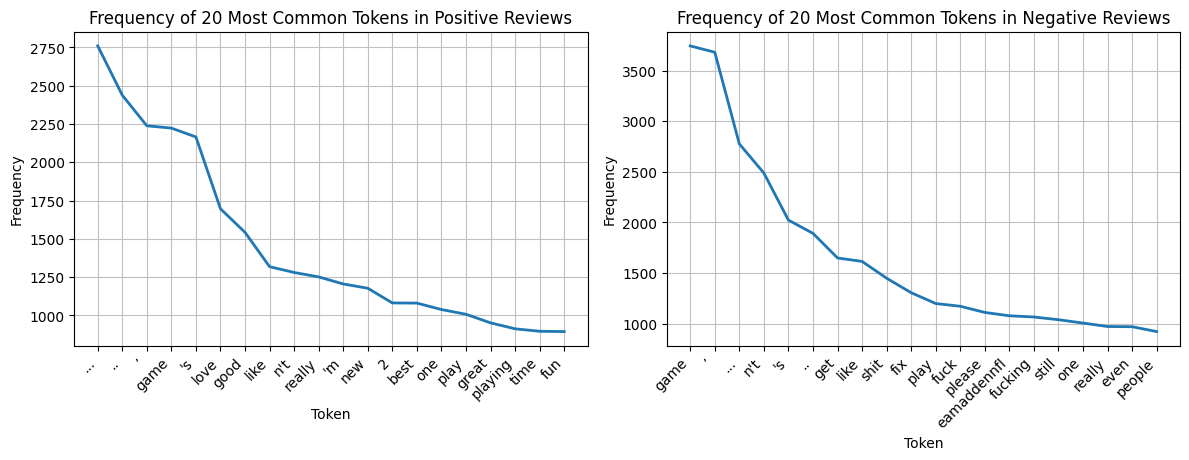

In [7]:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)

word_pos_fdist.plot(20, cumulative = False)
ax1 = plt.gca()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha = "right")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title("Frequency of 20 Most Common Tokens in Positive Reviews")

plt.subplot(2, 2, 2)

word_neg_fdist.plot(20, cumulative = False)
ax2 = plt.gca()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, ha = "right")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title("Frequency of 20 Most Common Tokens in Negative Reviews")


plt.tight_layout()
plt.show()

In [8]:
pos_review_bigrams = []
neg_review_bigrams = []

bigrams_location = df.columns.get_loc("bigrams")
sentiment_location = df.columns.get_loc("sentiment")

for i in range(0, len(df)):
  if df.iloc[i, sentiment_location] == "Negative":
    for bigram in df.iloc[i, bigrams_location]:
      pos_review_bigrams.append(bigram)

  else:
    for bigram in df.iloc[i, bigrams_location]:
      neg_review_bigrams.append(bigram)


bigram_pos_fdist = FreqDist(pos_review_bigrams)

bigram_neg_fdist = FreqDist(neg_review_bigrams)

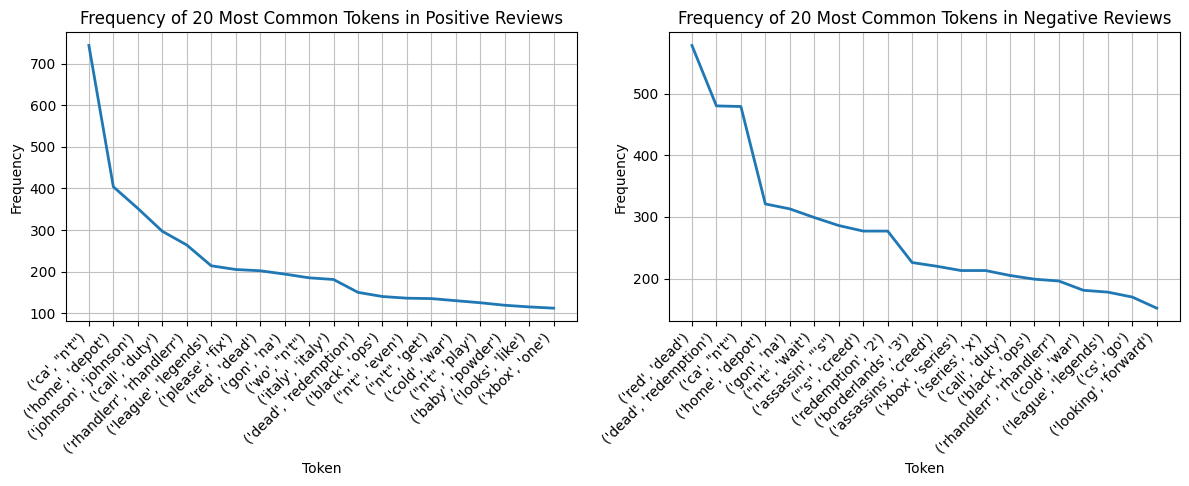

In [9]:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)

bigram_pos_fdist.plot(20, cumulative = False)
ax1 = plt.gca()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha = "right")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title("Frequency of 20 Most Common Tokens in Positive Reviews")

plt.subplot(2, 2, 2)

bigram_neg_fdist.plot(20, cumulative = False)
ax2 = plt.gca()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, ha = "right")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title("Frequency of 20 Most Common Tokens in Negative Reviews")


plt.tight_layout()
plt.show()

In [10]:
## Finding which frequently occuring Bigrams exist in both positive and negative sentiment reviews

from typing import Unpack
pos_neg_duplicate_bigrams = []

top_20_pos_bigrams = bigram_pos_fdist.most_common(20)
top_20_neg_bigrams = bigram_neg_fdist.most_common(20)

bigrams_temp, freq = zip(*top_20_pos_bigrams)
bigrams_temp_list = list(bigrams_temp)

for bigram, count in bigram_neg_fdist.most_common(20):
  if bigram in bigrams_temp_list:
    pos_neg_duplicate_bigrams.append(bigram)


In [11]:
data_to_add = []

for bigram, freq in top_20_pos_bigrams:
  if bigram in pos_neg_duplicate_bigrams:
    new_row = {
        "bigram" : bigram,
        "sentiment" : "Positive",
        "count" : freq
    }

    data_to_add.append(new_row)

for bigram, freq in top_20_neg_bigrams:
  if bigram in pos_neg_duplicate_bigrams:
    new_row = {
        "bigram" : bigram,
        "sentiment" : "Negative",
        "count" : freq
    }

    data_to_add.append(new_row)

df_duplicate_bigrams = pd.DataFrame(data_to_add)

totals = df_duplicate_bigrams.groupby("bigram").agg(
    total = ("count", "sum")
).reset_index()

combined = pd.merge(df_duplicate_bigrams, totals, how = "left", on = "bigram")

combined["proportion"] = round(combined["count"] / combined["total"], 2)

combined = combined.sort_values(by = ["sentiment", "count"], ascending = [False, True])

combined


,bigram,sentiment,count,total,proportion
9,"(cold, war)",Positive,130,311,0.42
8,"(black, ops)",Positive,140,339,0.41
7,"(dead, redemption)",Positive,150,630,0.24
6,"(gon, na)",Positive,194,507,0.38
5,"(red, dead)",Positive,202,780,0.26
4,"(league, legends)",Positive,214,392,0.55
3,"(rhandlerr, rhandlerr)",Positive,264,460,0.57
2,"(call, duty)",Positive,297,502,0.59
1,"(home, depot)",Positive,404,725,0.56
0,"(ca, n't)",Positive,744,1223,0.61


/tmp/ipython-input-369206820.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f"{count / df_stack.sum(axis = 1)[i]:.1%}" if count > 0 else ""
/tmp/ipython-input-369206820.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f"{count / df_stack.sum(axis = 1)[i]:.1%}" if count > 0 else ""
/tmp/ipython-input-369206820.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f"{count / df_stack.sum(axis = 1

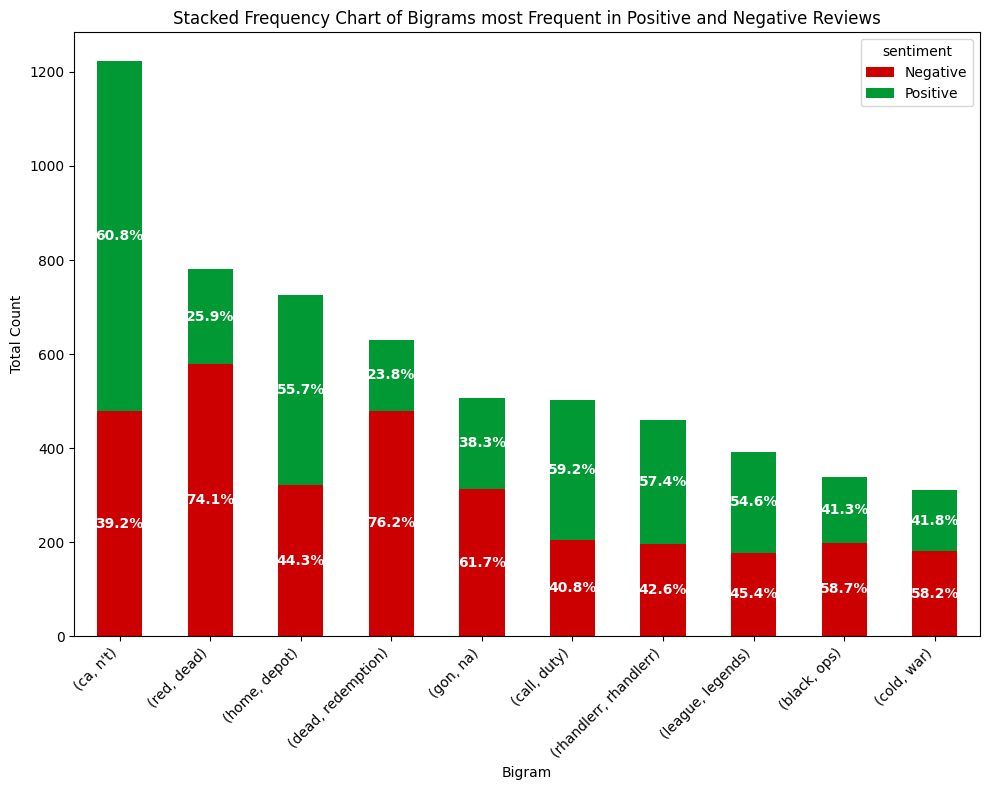

In [12]:
### Bar plot to show proportion of frequency of duplicate bigrams in the top 20 most frequent positive and negative Reviews

#pivot data for stacking
df_pivot = combined.pivot_table(
    index = "bigram",
    columns = "sentiment",
    values = "count"
)

#get index correct order based on total
total_sort_order = combined[["bigram", "total"]].drop_duplicates().sort_values(by = "total", ascending = False)["bigram"]

#reindex pivoted table
df_stack = df_pivot.reindex(total_sort_order)

#create stacked bar plot
ax = df_stack.plot(
    kind = "bar",
    stacked = True,
    figsize= (10, 8),
    color = {"Positive": "#009933", "Negative": "#cc0000"}
)

ax.set_title("Stacked Frequency Chart of Bigrams most Frequent in Positive and Negative Reviews")
ax.set_xlabel("Bigram")
ax.set_ylabel("Total Count")

for container in ax.containers:
    labels = [f"{count / df_stack.sum(axis = 1)[i]:.1%}" if count > 0 else ""
    for i, count in enumerate(container.datavalues)]
    ax.bar_label(container, labels = labels, label_type = "center", color = "white", weight = "bold")

plt.xticks(rotation = 45, ha = "right")
plt.tight_layout()

In [19]:
# TF - IDF
df_copy = df
# df_copy.head()

# Split the dataframe by sentiment
df_positive = df_copy[df_copy['sentiment'] == 'Positive'].copy()
df_negative = df_copy[df_copy['sentiment'] == 'Negative'].copy()

print(f"Positive reviews: {len(df_positive)}")
print(f"Negative reviews: {len(df_negative)}")


Positive reviews: 18982
Negative reviews: 21096


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Function to get top N words using TF-IDF
def get_top_words_tfidf(texts, top_n=10):
    """
    Apply TF-IDF and return top N words
    """
    vectorizer = TfidfVectorizer(
        max_features=1000,
        min_df=5,
        max_df=0.95,
        ngram_range=(1, 1),  # Only single words
        stop_words='english'
    )

    # Fit and transform
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # Calculate mean TF-IDF score for each word
    mean_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).flatten()

    # Get top N words
    top_indices = mean_tfidf.argsort()[-top_n:][::-1]

    top_words = pd.DataFrame({
        'word': [feature_names[i] for i in top_indices],
        'tfidf_score': [mean_tfidf[i] for i in top_indices]
    })

    return top_words

# Get top 10 words for positive reviews
print("TOP 10 WORDS - POSITIVE REVIEWS")

top_positive = get_top_words_tfidf(df_positive['cleaned_text'], top_n=10)
print(top_positive)

# Get top 10 words for negative reviews
print("\nTOP 10 WORDS - NEGATIVE REVIEWS")

top_negative = get_top_words_tfidf(df_negative['cleaned_text'], top_n=10)
print(top_negative)

TOP 10 WORDS - POSITIVE REVIEWS
     word  tfidf_score
0    love     0.027550
1    game     0.025304
2    good     0.023647
3     com     0.021955
4    just     0.019898
5    best     0.017615
6    like     0.017463
7  really     0.017071
8     pic     0.017043
9     new     0.016003

TOP 10 WORDS - NEGATIVE REVIEWS
          word  tfidf_score
0         game     0.032276
1         just     0.021525
2         shit     0.021003
3          com     0.019732
4         fuck     0.019324
5         like     0.016938
6      twitter     0.015913
7          pic     0.015815
8  eamaddennfl     0.015516
9          fix     0.015343
